In [65]:
from __future__ import print_function
from __future__ import division
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy
print("PyTorch Version: ",torch.__version__)
print("Torchvision Version: ",torchvision.__version__)
input_size = (224,224)


criterion = nn.CrossEntropyLoss()
# Data Transformations

data_dir = 'z'
data_transforms = {
    'train': transforms.Compose([
        transforms.Resize(input_size),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(input_size),
        transforms.CenterCrop(input_size),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

print("Initializing Datasets and Dataloaders...")

# Create training and validation datasets
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x]) for x in ['train', 'val']}
# Create training and validation dataloaders
dataloaders_dict = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=batch_size, shuffle=True, num_workers=4) for x in ['train', 'val']}
print(len(image_datasets['train'])) # Number of training images
print(len(dataloaders_dict['train'])) # Equal to #Training images / Batch Size
print(len(dataloaders_dict['train'].dataset)) # Also equal to number of training images
print(len(image_datasets['train'])/batch_size) # Equal to #Training images / Batch Size
data = next(iter(dataloaders_dict['train']))
print(len(data[0]),"1") 
print(dataloaders_dict['train'].dataset[0])
# Detect if we have a GPU available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

class_names = image_datasets['train'].classes


PyTorch Version:  1.11.0
Torchvision Version:  0.12.0
Initializing Datasets and Dataloaders...
2038
255
2038
254.75
8 1
(tensor([[[2.2489, 2.2489, 2.2489,  ..., 2.2489, 2.2489, 2.2489],
         [2.2489, 2.2489, 2.2489,  ..., 2.2489, 2.2489, 2.2489],
         [2.2489, 2.2489, 2.2489,  ..., 2.2489, 2.2489, 2.2489],
         ...,
         [2.2489, 2.2489, 2.2489,  ..., 2.2489, 2.2489, 2.2489],
         [2.2489, 2.2489, 2.2489,  ..., 2.2489, 2.2489, 2.2489],
         [2.2489, 2.2489, 2.2489,  ..., 2.2489, 2.2489, 2.2489]],

        [[2.4286, 2.4286, 2.4286,  ..., 2.4286, 2.4286, 2.4286],
         [2.4286, 2.4286, 2.4286,  ..., 2.4286, 2.4286, 2.4286],
         [2.4286, 2.4286, 2.4286,  ..., 2.4286, 2.4286, 2.4286],
         ...,
         [2.4286, 2.4286, 2.4286,  ..., 2.4286, 2.4286, 2.4286],
         [2.4286, 2.4286, 2.4286,  ..., 2.4286, 2.4286, 2.4286],
         [2.4286, 2.4286, 2.4286,  ..., 2.4286, 2.4286, 2.4286]],

        [[2.6400, 2.6400, 2.6400,  ..., 2.6400, 2.6400, 2.6400],
  

In [16]:
model_name = "squeezenet"

# Number of classes in the dataset
num_classes = 18

# Batch size for training (change depending on how much memory you have)
batch_size = 8

# Number of epochs to train for
num_epochs = 15

# Flag for feature extracting. When False, we finetune the whole model,
#   when True we only update the reshaped layer params
feature_extract = True

No handles with labels found to put in legend.


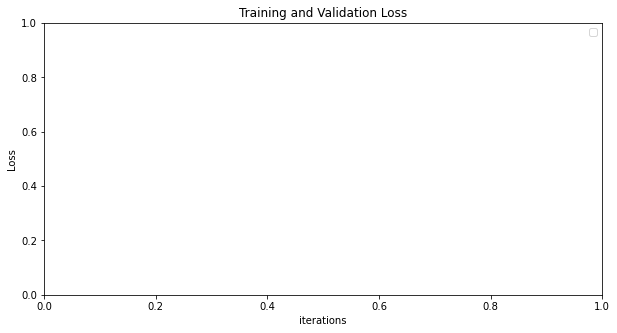

In [75]:

plt.figure(figsize=(10,5))
plt.title("Training and Validation Loss")
#plt.plot(train_losses,label="train")






def train_model(model, dataloaders, criterion, optimizer, num_epochs=25, is_inception=False):
    since = time.time()

    val_acc_history = []

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
     # Iterates over # of epochs
    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            # If phase equals train, then the model(resnet, vgg, etc.) is put into train mode
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            
            for inputs, labels in dataloaders[phase]:
                print(phase)
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    # Get model outputs and calculate loss
                    # Special case for inception because in training it has an auxiliary output. In train
                    #   mode we calculate the loss by summing the final output and the auxiliary output
                    #   but in testing we only consider the final output.
                    if is_inception and phase == 'train':
                        # From https://discuss.pytorch.org/t/how-to-optimize-inception-model-with-auxiliary-classifiers/7958
                        outputs, aux_outputs = model(inputs)
                        loss1 = criterion(outputs, labels)
                        loss2 = criterion(aux_outputs, labels)
                        loss = loss1 + 0.4*loss2
                    else:
                        outputs = model(inputs)
                        loss = criterion(outputs, labels)

                    _, preds = torch.max(outputs, 1)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
          #  len(dataloaders_dict['train'].dataset = Total num img in training set
           #  len(dataloaders_dict['val'].dataset = Total num img in val set
            # The phase variable is either val or train and represents that repsective data set
            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_acc = running_corrects.double() / len(dataloaders[phase].dataset)

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
            if phase == 'val':
                val_acc_history.append(epoch_acc)

        #print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    plt.plot(val_acc_history,label="val")
    return model, val_acc_history
#print(image_datasets.dataset)
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [18]:
def set_parameter_requires_grad(model, feature_extracting):
    if feature_extracting:
        for param in model.parameters():
            param.requires_grad = False

In [19]:
def initialize_model(model_name, num_classes, feature_extract, use_pretrained=True):
    # Initialize these variables which will be set in this if statement. Each of these
    #   variables is model specific.
    model_ft = None
    input_size = 0

    if model_name == "resnet":
        """ Resnet18
        """
        model_ft = models.resnet18(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.fc.in_features
        model_ft.fc = nn.Linear(num_ftrs, num_classes)
        input_size = 224

    elif model_name == "alexnet":
        """ Alexnet
        """
        model_ft = models.alexnet(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.classifier[6].in_features
        model_ft.classifier[6] = nn.Linear(num_ftrs,num_classes)
        input_size = 224

    elif model_name == "vgg":
        """ VGG11_bn
        """
        model_ft = models.vgg11_bn(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.classifier[6].in_features
        model_ft.classifier[6] = nn.Linear(num_ftrs,num_classes)
        input_size = 224

    elif model_name == "squeezenet":
        """ Squeezenet
        """
        model_ft = models.squeezenet1_0(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        model_ft.classifier[1] = nn.Conv2d(512, num_classes, kernel_size=(1,1), stride=(1,1))
        
        model_ft.num_classes = num_classes
        input_size = 224

    elif model_name == "densenet":
        """ Densenet
        """
        model_ft = models.densenet121(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.classifier.in_features
        model_ft.classifier = nn.Linear(num_ftrs, num_classes)
        input_size = 224

    elif model_name == "inception":
        """ Inception v3
        Be careful, expects (299,299) sized images and has auxiliary output
        """
        model_ft = models.inception_v3(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        # Handle the auxilary net
        num_ftrs = model_ft.AuxLogits.fc.in_features
        model_ft.AuxLogits.fc = nn.Linear(num_ftrs, num_classes)
        # Handle the primary net
        num_ftrs = model_ft.fc.in_features
        model_ft.fc = nn.Linear(num_ftrs,num_classes)
        input_size = 299

    else:
        print("Invalid model name, exiting...")
        exit()

    return model_ft, input_size

# Initialize the model for this run
model_ft, input_size = initialize_model(model_name, num_classes, feature_extract, use_pretrained=True)

# Print the model we just instantiated
print(model_ft)

SqueezeNet(
  (features): Sequential(
    (0): Conv2d(3, 96, kernel_size=(7, 7), stride=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
    (3): Fire(
      (squeeze): Conv2d(96, 16, kernel_size=(1, 1), stride=(1, 1))
      (squeeze_activation): ReLU(inplace=True)
      (expand1x1): Conv2d(16, 64, kernel_size=(1, 1), stride=(1, 1))
      (expand1x1_activation): ReLU(inplace=True)
      (expand3x3): Conv2d(16, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (expand3x3_activation): ReLU(inplace=True)
    )
    (4): Fire(
      (squeeze): Conv2d(128, 16, kernel_size=(1, 1), stride=(1, 1))
      (squeeze_activation): ReLU(inplace=True)
      (expand1x1): Conv2d(16, 64, kernel_size=(1, 1), stride=(1, 1))
      (expand1x1_activation): ReLU(inplace=True)
      (expand3x3): Conv2d(16, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (expand3x3_activation): ReLU(inplace=True)
    )
    (5): Fire(
   

In [20]:
# Send the model to GPU
device = "cpu"
model_ft = model_ft.to(device)

# Gather the parameters to be optimized/updated in this run. If we are
#  finetuning we will be updating all parameters. However, if we are
#  doing feature extract method, we will only update the parameters
#  that we have just initialized, i.e. the parameters with requires_grad
#  is True.
params_to_update = model_ft.parameters()
print("Params to learn:")
if feature_extract:
    params_to_update = []
    for name,param in model_ft.named_parameters():
        if param.requires_grad == True:
            params_to_update.append(param)
            print("\t",name)
else:
    for name,param in model_ft.named_parameters():
        if param.requires_grad == True:
            print("\t",name)

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(params_to_update, lr=0.001, momentum=0.9)

Params to learn:
	 classifier.1.weight
	 classifier.1.bias


criterion = nn.CrossEntropyLoss()

model_ft, hist = train_model(model_ft, dataloaders_dict, criterion, optimizer_ft, num_epochs=num_epochs, is_inception=(model_name=="inception"))

Epoch 0/29
----------
train
train
train
train
train
train
train
train
train
train
train
train
train
train
train
train
train
train
train
train
train
train
train
train
train
train
train
train
train
train
train
train
train
train
train
train
train
train
train
train
train
train
train
train
train
train
train
train
train
train
train
train
train
train
train
train
train
train
train
train
train
train
train
train
train
train
train
train
train
train
train
train
train
train
train
train
train
train
train
train
train
train
train
train
train
train
train
train
train
train
train
train
train
train
train
train
train
train
train
train
train
train
train
train
train
train
train
train
train
train
train
train
train
train
train
train
train
train
train
train
train
train
train
train
train
train
train
train
train
train
train
train
train
train
train
train
train
train
train
train
train
train
train
train
train
train
train
train
train
train
train
train
train
train
train
train
train
train
train
train
train
train
train


train
train
train
train
train
train
train
train
train
train
train
train
train
train
train
train
train
train
train
train
train
train
train
train
train
train
train
train
train
train
train
train
train
train
train
train
train
train
train
train
train
train
train
train
train
train
train
train
train
train
train
train
train
train
train
train
train
train
train
train
train
train
train
train
train
train
train
train
train
train
train
train
train
train
train
train
train
train
train
train
train
train
train
train
train
train
train
train
train
train
train
train
train
train
train
train
train
train
train
train
train
train
train
train
train
train
train
train
train
train
train
train
train
train
train
train
train
train
train
train
train
train
train
train
train
train
train
train Loss: 0.2102 Acc: 0.9392
val
val
val
val
val
val
val
val
val
val
val
val
val
val
val
val
val
val
val
val
val
val
val
val
val
val
val
val
val
val
val
val
val
val
val
val
val
val
val
val
val
val
val
val
val
val
val
val
val
val
val
val

val
val
val
val
val
val
val
val
val
val
val
val
val
val
val
val
val
val
val
val
val
val
val
val
val
val
val
val
val
val
val
val
val
val
val
val
val
val
val
val
val
val
val
val
val
val
val
val
val
val
val
val
val
val
val
val
val
val
val
val
val Loss: 0.3480 Acc: 0.9165
Epoch 9/29
----------
train
train
train
train
train
train
train
train
train
train
train
train
train
train
train
train
train
train
train
train
train
train
train
train
train
train
train
train
train
train
train
train
train
train
train
train
train
train
train
train
train
train
train
train
train
train
train
train
train
train
train
train
train
train
train
train
train
train
train
train
train
train
train
train
train
train
train
train
train
train
train
train
train
train
train
train
train
train
train
train
train
train
train
train
train
train
train
train
train
train
train
train
train
train
train
train
train
train
train
train
train
train
train
train
train
train
train
train
train
train
train
train
train
train
train
train
train
train
t

train
train
train
train
train
train
train
train
train
train
train
train
train
train
train
train
train
train
train
train
train
train
train
train
train
train
train
train
train
train
train
train
train
train
train
train
train
train
train
train
train
train
train
train
train
train
train
train
train
train
train
train
train
train
train
train
train
train
train
train
train
train
train
train
train
train
train
train
train
train
train
train
train
train
train
train
train
train
train
train
train
train
train
train
train
train
train
train
train
train
train
train
train
train
train
train
train
train
train
train
train
train
train
train
train
train
train
train
train
train
train
train
train
train
train
train
train
train
train
train
train
train
train
train
train
train
train
train
train
train
train
train
train
train
train
train
train
train
train
train
train
train
train
train
train
train
train
train
train
train
train
train
train
train
train
train
train
train
train
train
train
train
train
train
train
train
trai

train
train
train
train
train
train
train
train
train
train
train
train
train
train
train
train
train
train
train
train
train
train
train
train
train
train
train
train
train
train
train
train
train
train
train
train
train
train
train
train
train
train
train Loss: 0.0814 Acc: 0.9760
val
val
val
val
val
val
val
val
val
val
val
val
val
val
val
val
val
val
val
val
val
val
val
val
val
val
val
val
val
val
val
val
val
val
val
val
val
val
val
val
val
val
val
val
val
val
val
val
val
val
val
val
val
val
val
val
val
val
val
val
val Loss: 0.3306 Acc: 0.9123
Epoch 18/29
----------
train
train
train
train
train
train
train
train
train
train
train
train
train
train
train
train
train
train
train
train
train
train
train
train
train
train
train
train
train
train
train
train
train
train
train
train
train
train
train
train
train
train
train
train
train
train
train
train
train
train
train
train
train
train
train
train
train
train
train
train
train
train
train
train
train
train
train
train
train
train
train

train
train
train
train
train
train
train
train
train
train
train
train
train
train
train
train
train
train
train
train
train
train
train
train
train
train
train
train
train
train
train
train
train
train
train
train
train
train
train
train
train
train
train
train
train
train
train
train
train
train
train
train
train
train
train
train
train
train
train
train
train
train
train
train
train
train
train
train
train
train
train
train
train
train
train
train
train
train
train
train
train
train
train
train
train
train
train
train
train
train
train
train
train
train
train
train
train
train
train
train
train
train
train
train
train
train
train
train
train
train
train
train
train
train
train
train
train
train
train
train
train
train
train
train
train
train
train
train
train
train
train
train
train
train
train
train
train
train
train
train
train
train
train
train
train
train
train
train
train
train
train
train
train
train
train
train
train
train
train
train
train
train
train
train
train
train
trai

train
train
train
train
train
train
train
train
train
train
train
train
train
train
train
train
train
train
train
train
train
train
train
train
train
train
train
train
train
train
train
train
train
train
train
train
train
train
train
train
train
train
train
train
train
train
train
train
train
train
train
train
train
train
train
train
train
train
train
train
train
train
train
train
train
train
train
train
train
train
train
train
train
train
train
train
train
train
train
train
train
train
train
train
train
train
train
train
train
train Loss: 0.0642 Acc: 0.9814
val
val
val
val
val
val
val
val
val
val
val
val
val
val
val
val
val
val
val
val
val
val
val
val
val
val
val
val
val
val
val
val
val
val
val
val
val
val
val
val
val
val
val
val
val
val
val
val
val
val
val
val
val
val
val
val
val
val
val
val
val Loss: 0.3704 Acc: 0.9123
Epoch 27/29
----------
train
train
train
train
train
train
train
train
train
train
train
train
train
train
train
train
train
train
train
train
train
train
train
train

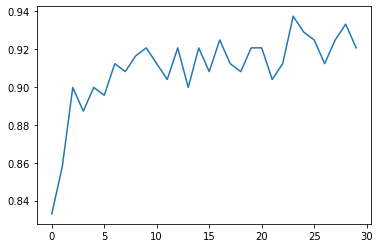

In [78]:
criterion = nn.CrossEntropyLoss()

# Train and evaluate
model_ft, hist = train_model(model_ft, dataloaders_dict, criterion, optimizer_ft, num_epochs=30, is_inception=(model_name=="inception"))

In [72]:
img, label = next(iter(dataloaders_dict['val']))
print

<function print>

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


predicted:  speed_limit_45
actual:  speed_limit_45


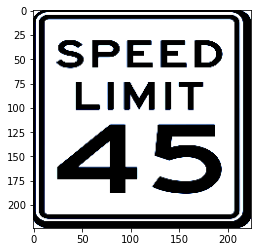

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


predicted:  do_not_enter
actual:  do_not_enter


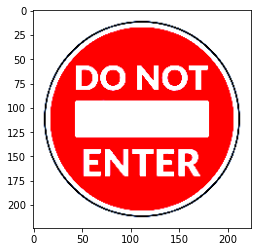

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


predicted:  speed_limit_35
actual:  speed_limit_35


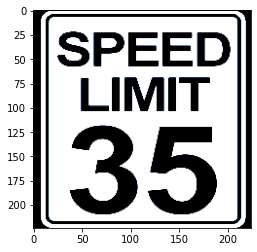

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


predicted:  signal_ahead
actual:  signal_ahead


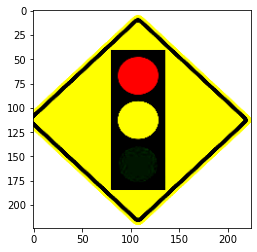

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


predicted:  speed_limit_55
actual:  speed_limit_55


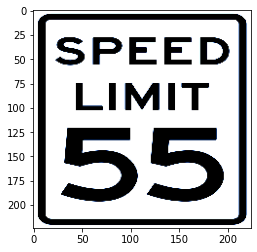

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


predicted:  pedestrian_crossing
actual:  school_zone


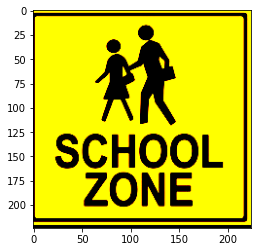

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


predicted:  curve_right
actual:  curve_right


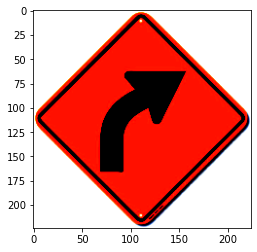

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


predicted:  signal_ahead
actual:  signal_ahead


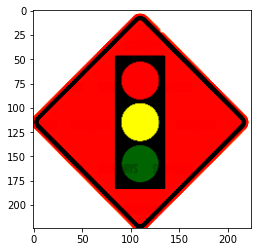

In [73]:
#fig, axes = plt.subplots(8,1, figsize=(8,1))
outputs = model_ft(img)
_, preds = torch.max(outputs, 1)
import numpy as np
for i in range(len(img)):
    #labels = labels.to(device)
    
    print("predicted: ", class_names[preds[i]])
    print("actual: ", class_names[label[i]])
    #img = img.numpy.permute(1,2,0)
    plt.imshow(img[i].permute(1,2,0))
    plt.show()
                    

    
    
    

    
    

NameError: name 'val_acc_history' is not defined

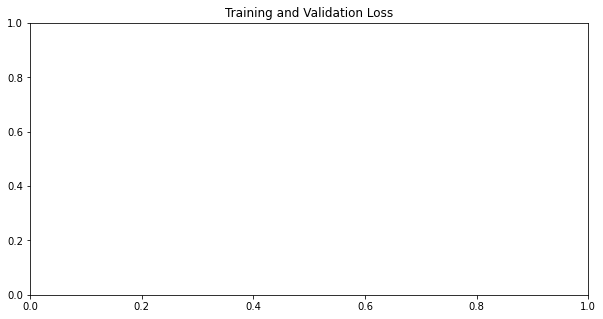

In [74]:
plt.figure(figsize=(10,5))
plt.title("Training and Validation Loss")
plt.plot(val_acc_history,label="val")
#plt.plot(train_losses,label="train")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [94]:
torch.save(model_ft, 'squeezenet')

In [96]:
model_ft = torch.load('squeezenet')

In [97]:
model_ft, hist = train_model(model_ft, dataloaders_dict, criterion, optimizer_ft, num_epochs=30, is_inception=(model_name=="inception"))

Epoch 0/29
----------
train
train
train
train
train
train
train
train
train
train
train
train
train
train
train
train
train
train
train
train
train
train
train
train
train
train
train
train
train
train
train
train
train
train
train
train
train
train
train
train
train
train
train
train
train
train
train
train
train
train
train
train
train
train
train
train
train
train
train
train
train
train
train
train
train
train
train
train
train
train
train
train
train
train
train
train
train
train
train
train
train
train
train
train
train
train
train
train
train
train
train
train
train
train
train
train
train
train
train
train
train
train
train
train
train
train
train
train
train
train
train
train
train
train
train
train
train
train
train
train
train
train
train
train
train
train
train
train
train
train
train
train
train
train
train
train
train
train
train
train
train
train
train
train
train
train
train
train
train
train
train
train
train
train
train
train
train
train
train
train
train
train
train


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fdb0a5368b0>
Traceback (most recent call last):
  File "/Users/omarabdelazim/opt/anaconda3/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1358, in __del__
    self._shutdown_workers()
  File "/Users/omarabdelazim/opt/anaconda3/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1322, in _shutdown_workers
    w.join(timeout=_utils.MP_STATUS_CHECK_INTERVAL)
  File "/Users/omarabdelazim/opt/anaconda3/lib/python3.9/multiprocessing/process.py", line 149, in join
    res = self._popen.wait(timeout)
  File "/Users/omarabdelazim/opt/anaconda3/lib/python3.9/multiprocessing/popen_fork.py", line 40, in wait
    if not wait([self.sentinel], timeout):
  File "/Users/omarabdelazim/opt/anaconda3/lib/python3.9/multiprocessing/connection.py", line 936, in wait
    ready = selector.select(timeout)
  File "/Users/omarabdelazim/opt/anaconda3/lib/python3.9/selectors.py", line 416, in select
    fd_

train


KeyboardInterrupt: 

In [98]:
torch.save(model_ft, 'squeezenet')